<a href="https://colab.research.google.com/github/TripopN/CNN-fine-tuning/blob/main/Xception_with_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [115]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2


# GPU Checking

In [2]:
# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# Set Seed

In [3]:
# Set seeds for reproducibility
seed_value = 1234  # You can use any number here
tf.random.set_seed(seed_value)  # Set TensorFlow seed
np.random.seed(seed_value)  # Set NumPy seed
random.seed(seed_value)  # Set Python random seed (optional)

# Import Dataset and Prepare dataset

## Import data set

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [128]:
# define zip file path
zip_path = '/content/drive/MyDrive/DADS7202/homework01/dataset.zip'
# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# List the extracted folders to verify
print(os.listdir('/content/dataset'))


['Giant', 'Shizuka', 'Doraemon', 'Nobita', 'Zunio']


## Convert Images to .npy format

In [129]:
# Set up the directory paths
data_dir = '/content/dataset/'
classes = ['Doraemon', 'Giant', 'Nobita', 'Shizuka', 'Zunio']  # Class names

# Create empty lists to store the images and labels
images = []
labels = []

# Resize all images to 224x224 (Xception's input size)
target_size = (224, 224)

for label, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        # Load the image, resize it, and convert to array
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)

        # Append the image and label to lists
        images.append(img_array)
        labels.append(label)

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Save images and labels as .npy files
np.save('/content/images.npy', images)
np.save('/content/labels.npy', labels)

print(f'Saved {len(images)} images to images.npy')
print(f'Saved {len(labels)} labels to labels.npy')


Saved 533 images to images.npy
Saved 533 labels to labels.npy


### Data review.

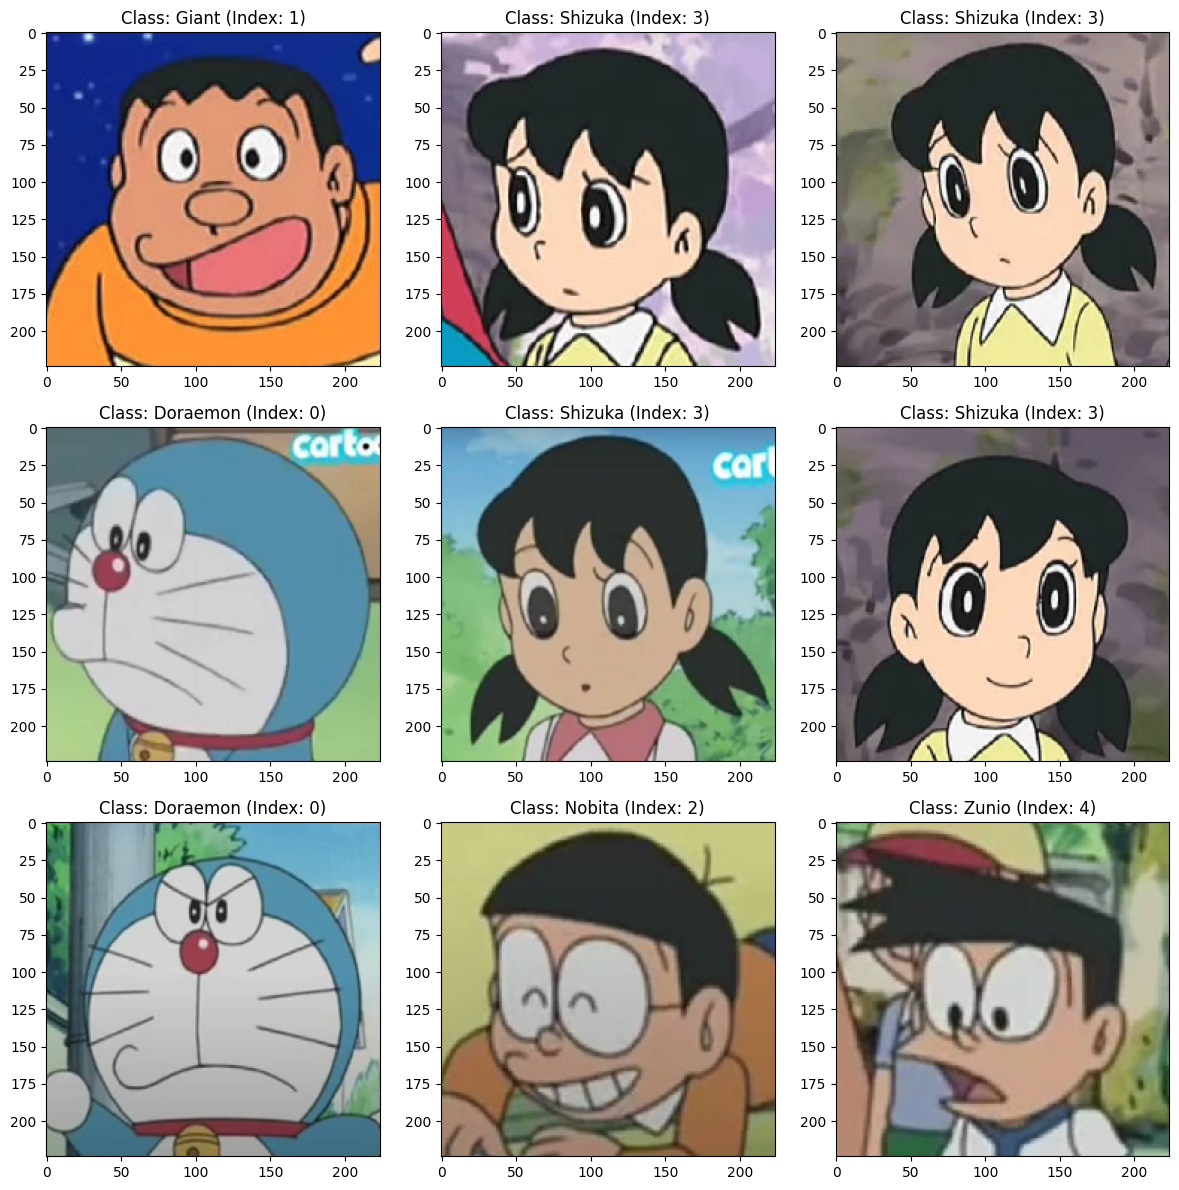

In [130]:
# Plot a few random examples from the dataset
plt.figure(figsize=(12, 12))

# Choose 9 random images to display
num_images = 9
random_indices = random.sample(range(len(images)), num_images)

for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    img = images[idx].astype('uint8')  # Convert to uint8 for display
    label = labels[idx]  # Get the label (index) for the image

    # Plot the image and set the title to the corresponding class name and index
    plt.imshow(img)
    plt.title(f"Class: {classes[label]} (Index: {label})")
    #plt.axis('off')  # Hide the axes

# Show the plot
plt.tight_layout()
plt.show()

In [131]:
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (533, 224, 224, 3)
Labels shape: (533,)


## Split the Data into Training, Test Sets, Validation Sets.

Test 20%
Train 80%
Validation 30%

In [132]:
# Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Now, split the training data into 70% training and 30% validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Test samples: {len(x_test)}")


Training samples: 298
Validation samples: 128
Test samples: 107


## Convert labels to one-hot encoding.

In [133]:
#ไม่ convert เพราะว่า Loss function ใช้ ตัวเลขได้
'''# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=5)  # 5 classes: Doraemon, Giant, Nobita, Shizuka, Zunio
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)'''


'# Convert labels to one-hot encoding\ny_train = to_categorical(y_train, num_classes=5)  # 5 classes: Doraemon, Giant, Nobita, Shizuka, Zunio\ny_val = to_categorical(y_val, num_classes=5)\ny_test = to_categorical(y_test, num_classes=5)'

## Preprocess input data.

In [134]:
# Preprocess the images for Xception
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
x_test = preprocess_input(x_test)


In [135]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(298, 224, 224, 3)
(128, 224, 224, 3)
(107, 224, 224, 3)


## Data augmentation

In [136]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rotation_range=60,
    zoom_range=0.5,
    width_shift_range=5.0,
    height_shift_range=5.0,
    horizontal_flip=True,
    fill_mode='nearest'
    #samplewise_center=True, #ปิดก่อนเพราะว่าทำ Preprocess ไปแล้ว
    #samplewise_std_normalization=True #ปิดก่อนเพราะว่าทำ Preprocess ไปแล้ว
)

# No need for .fit() when using flow() on NumPy arrays
# .fit() is used for zca_whitening; you can remove it for your case

# Apply augmentation to the training set
train_generator = train_datagen.flow(x_train, y_train, batch_size=16, shuffle=False)

# For validation and test sets, no augmentation, just rescaling
val_test_datagen = ImageDataGenerator()

# No augmentation on validation and test sets
val_generator = val_test_datagen.flow(x_val, y_val, batch_size=16, shuffle=False)
test_generator = val_test_datagen.flow(x_test, y_test, batch_size=16, shuffle=False)


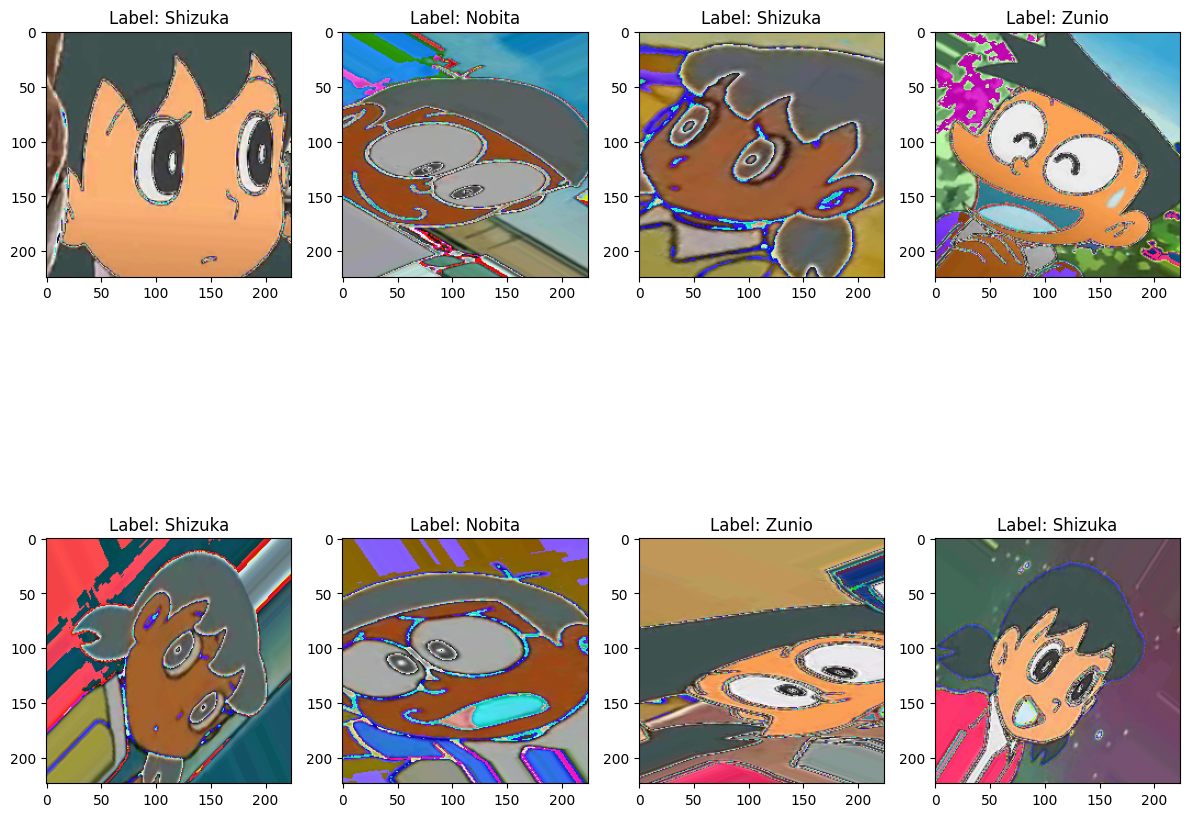

In [137]:
# Fetch a batch of augmented images and their labels
images_batch, labels_batch = next(train_generator)

# Plot a few augmented images (let's say 8)
plt.figure(figsize=(12, 12))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    img = images_batch[i]*255  # Multiply by 255 to convert back to the 0-255 range
    img = img.astype('uint8')  # Convert to uint8 for display
    label = labels_batch[i]
    plt.imshow(img)
    plt.title(f"Label: {classes[label]}")
plt.tight_layout()
plt.show()


# Pre-trained model without fine tuning.

In this case, we will use the pre-trained Xception model with its pre-trained weights (on ImageNet), but we won't train any of the layers. We will just add a new output layer on top of the pre-trained model to match the number of classes in your Doraemon dataset.

In [138]:
# Load pre-trained Xception model
xc_extractor = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (no fine-tuning)
xc_extractor.trainable = False  # Keep the base Xception model frozen

# Add custom layers to the model with L2 regularization and Dropout
x = Flatten()(xc_extractor.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Add L2 regularization
x = BatchNormalization()(x)  # Add Batch Normalization
x = Dropout(0.5)(x)  # Add Dropout to prevent overfitting
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Another Dense layer with L2
x = BatchNormalization()(x)  # Batch Normalization again
x = Dropout(0.5)(x)  # Another Dropout layer
new_outputs = Dense(5, activation='softmax')(x)  # Output layer for 5 classes

# Construct the final model
model = Model(inputs=xc_extractor.inputs, outputs=new_outputs)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.001),  # Lower learning rate to prevent overfitting
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 72,511,533 (276.61 MB)

 Trainable params: 51,648,005 (197.02 MB)

 Non-trainable params: 20,863,528 (79.59 MB)

In [139]:
# Generate and save the plot
plot_model(model, to_file='model_network.png', show_shapes=True, show_layer_names=True)

# Display the saved plot
Image(filename='model_network.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.746027 to fit



# Check point callback.

In [140]:
checkpoint_filepath = "bestweights.weights.h5"  # Update file extension

# Define the checkpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only the model weights
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model with the maximum validation accuracy
    save_best_only=True  # Only save the model if it's the best one
)


# Train model

In [141]:
# Train the model with the checkpoint callback
history = model.fit(
    train_generator,  # Augmented data generator for training
    validation_data=val_generator,  # Validation data generator
    epochs=30,  # Adjust based on your needs
    callbacks=[model_checkpoint_callback]  # Add the checkpoint callback
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3709 - loss: 3.8145 - val_accuracy: 0.4844 - val_loss: 4.8025
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6998 - loss: 3.5927 - val_accuracy: 0.8281 - val_loss: 3.2586
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7370 - loss: 3.5995 - val_accuracy: 0.8594 - val_loss: 3.1319
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7857 - loss: 3.4378 - val_accuracy: 0.9219 - val_loss: 2.9566
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.7818 - loss: 3.2067 - val_accuracy: 0.9141 - val_loss: 2.9093
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 0.8560 - loss: 3.1253 - val_accuracy: 0.9141 - val_loss: 2.8018
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8294 - loss: 3.0941 - val_accuracy: 0.9453 - val_loss: 2.6726
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - accuracy: 0.8499 - loss: 3.0903 - val_accuracy: 0.9453 - val_loss: 2.7

In [142]:
# Load the best weights from the checkpoint file
checkpoint_filepath = "bestweights.weights.h5"
model.load_weights(checkpoint_filepath)

print("Best weights loaded from:", checkpoint_filepath)


Best weights loaded from: bestweights.weights.h5


# Model evaluate.

In [143]:
# Evaluate the model on the test data after loading the best weights
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.9767 - loss: 2.0452
Test Loss: 2.0728
Test Accuracy: 0.9626


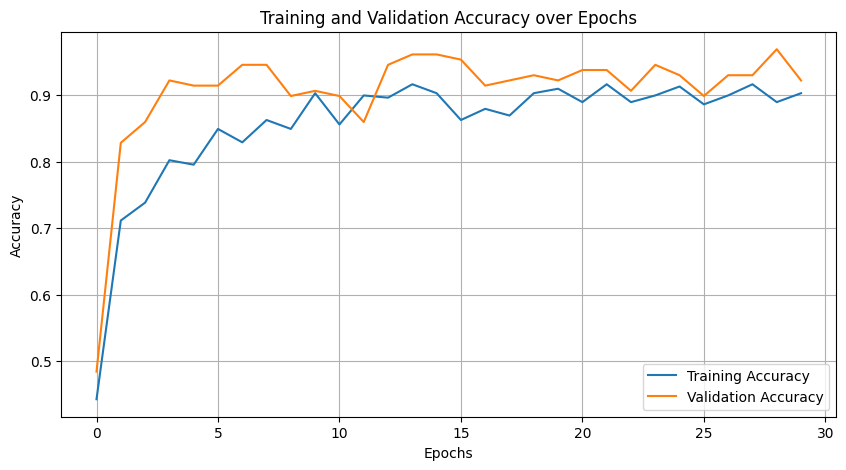

In [144]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


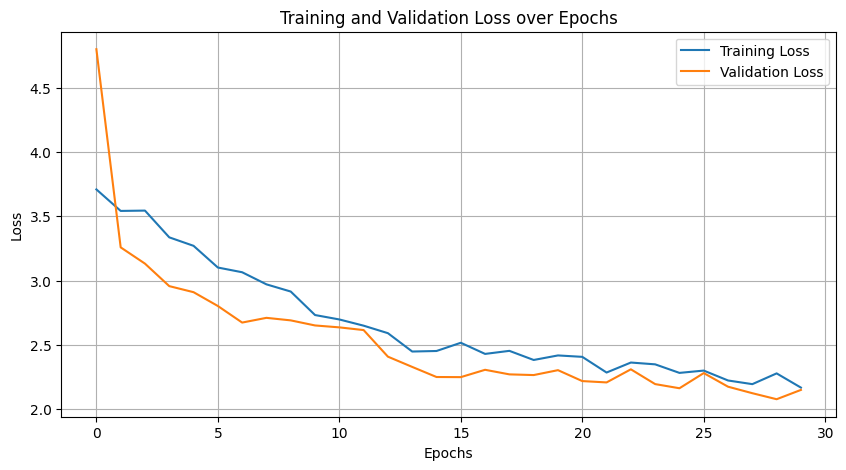

In [145]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Make predition.

In [146]:
# Assuming y_test contains the true labels
true_labels = y_test

# Predict the classes for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class labels


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step


In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[20  0  2  0  0]
 [ 0 20  1  0  0]
 [ 0  0 21  0  1]
 [ 0  0  0 22  0]
 [ 0  0  0  0 20]]


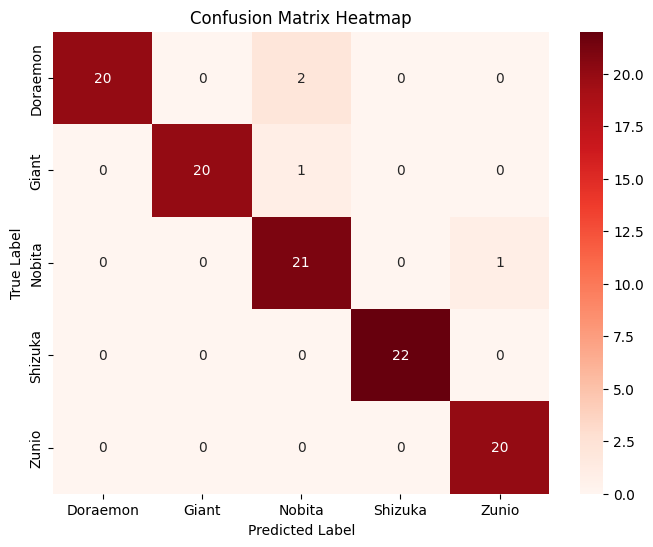

In [148]:
# Define the class names for your dataset (assuming they are in the same order as your labels)
class_names = ['Doraemon', 'Giant', 'Nobita', 'Shizuka', 'Zunio']

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [149]:
'''# Define class names
label = ['Doraemon', 'Giant', 'Nobita', 'Shizuka', 'Zunio']

for i in range(5):
    # Make predictions for a single test image
    y_pred = model.predict(x_test[i].reshape(1, 224, 224, 3))

    # Rescale the image from [0, 1] range back to [0, 255] if needed
    img_to_display = x_test[i]

    # If the maximum value is <= 1, assume the image is normalized and rescale it back to [0, 255]
    if np.max(img_to_display) <= 1:
        img_to_display = img_to_display * 255

    # Display the image
    plt.imshow(img_to_display.astype('uint8'))  # Ensure it's in uint8 format for proper display

    # Get the predicted label and actual label
    predicted_label = np.argmax(y_pred)  # Get the index of the predicted class
    actual_label = y_test[i]

    # Ensure the predicted and actual labels are within range
    if predicted_label < len(label) and actual_label < len(label):
        # Display the title with predicted and actual labels
        plt.title(f'x_test[{i}]: predict = {predicted_label} ({label[predicted_label]}) , '
                  f'actual = {actual_label} ({label[actual_label]})')
    else:
        # If labels are out of range, display error message
        plt.title(f'Invalid prediction or actual label index for x_test[{i}]')

    # Show the plot
    plt.show()'''


"# Define class names\nlabel = ['Doraemon', 'Giant', 'Nobita', 'Shizuka', 'Zunio']\n\nfor i in range(5):\n    # Make predictions for a single test image\n    y_pred = model.predict(x_test[i].reshape(1, 224, 224, 3))\n    \n    # Rescale the image from [0, 1] range back to [0, 255] if needed\n    img_to_display = x_test[i]\n    \n    # If the maximum value is <= 1, assume the image is normalized and rescale it back to [0, 255]\n    if np.max(img_to_display) <= 1:  \n        img_to_display = img_to_display * 255\n    \n    # Display the image\n    plt.imshow(img_to_display.astype('uint8'))  # Ensure it's in uint8 format for proper display\n    \n    # Get the predicted label and actual label\n    predicted_label = np.argmax(y_pred)  # Get the index of the predicted class\n    actual_label = y_test[i]\n    \n    # Ensure the predicted and actual labels are within range\n    if predicted_label < len(label) and actual_label < len(label):\n        # Display the title with predicted and actua

# Grad cam